## Quantifying Centone Content in Arab Andalusian Music using TF-IDF
March - 2019

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append('../src/')

import extraction
import model
import persistence
import reporting

In [297]:
from collections import Counter
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load

Load mappings Nawba mappings and recording metadata

In [4]:
data_path = '../data/'

In [5]:
# Nawba Mappings to centones
nawba_centones = persistence.load_and_parse_centones_mapping(os.path.join(data_path, 'Centones_Nawba.csv'))
# Nawba Mappings to tabs
nawba_tabs = persistence.load_and_parse_nawba_tabs(os.path.join(data_path, 'nawba_tabs.json'))

# Recording Descriptions
andalusian_description =  pd.read_json(os.path.join(data_path, 'andalusian_description.json'))

### Download

Download all scores from dunya

In [6]:
dunya_token = '<INSERT DUNYA TOKEN HERE>'
scores_path = os.path.join(data_path, 'scores/')

In [7]:
scores = persistence.download_scores(andalusian_description, dunya_token, target_folder=scores_path)

In [8]:
# Replace tab with nawba
# (mbid, nawba)
mbid_nawba = [[x[0], nawba_tabs[x[1]]] for x in scores if x[1] in nawba_tabs]

# Nawba mbid lookup
nawba_mbid_lookup = {x[0]:x[1] for x in mbid_nawba}

### Pattern Extraction

Load all scores into a stream of notes

In [111]:
notes_dict = {}
chord_mbid = []

for i,(mbid, nawba) in enumerate(mbid_nawba):
    this_score_path = os.path.join(scores_path, mbid + '.xml')
    # Fails for scores with chords
    try:
        note_stream = persistence.pattern_stream_from_score(this_score_path, 4)
        notes_dict[mbid] = note_stream
    except Exception as e:
        print('{} contains chords and wont be counted'.format(mbid))
        chord_mbid.append(mbid)

final_scores = [x for x in scores if x[0] not in chord_mbid]

notes_indices = notes_dict.keys()
notes = notes_dict.values()

2d8e2820-e4cf-4dc8-b4f1-45f8fb65de9e contains chords and wont be counted


Extract bag of patterns from each score

In [112]:
mbid_patterns = [extraction.extract_pattern_grams(nt, min_n=3, max_n=10) for nt in notes]

In [113]:
# Convert indices from mbid to Nawba
full_nawba_indices = [nawba_mbid_lookup[x] for x in notes_indices]

In [298]:
# Counts of number off scores in each nawba for plotting later
nawba_scores = Counter(full_nawba_indices)

### TFIDF

Apply TF-IDF on corpus of bag of patterns

In [114]:
distributions = model.get_tfidf_distributions(mbid_patterns)

Average tf-idf for each pattern for each Nawba

In [151]:
frame_grouped = model.average_tfidf(distributions, full_nawba_indices)

In [152]:
frame_grouped[:5]

,index,pattern,tf-idf,frequency
0,Nawba_1,AA,0.000000,0
1,Nawba_1,AAA,0.000167,2034
2,Nawba_1,AAAA,0.000079,979
3,Nawba_1,AAAAA,0.000039,447
4,Nawba_1,AAAAAA,0.000016,163


### Results

Plot analysis results

In [141]:
# Initialise Nawba number to plot
i = 1

Repeatedly run these cells to iterate through all Nawbas

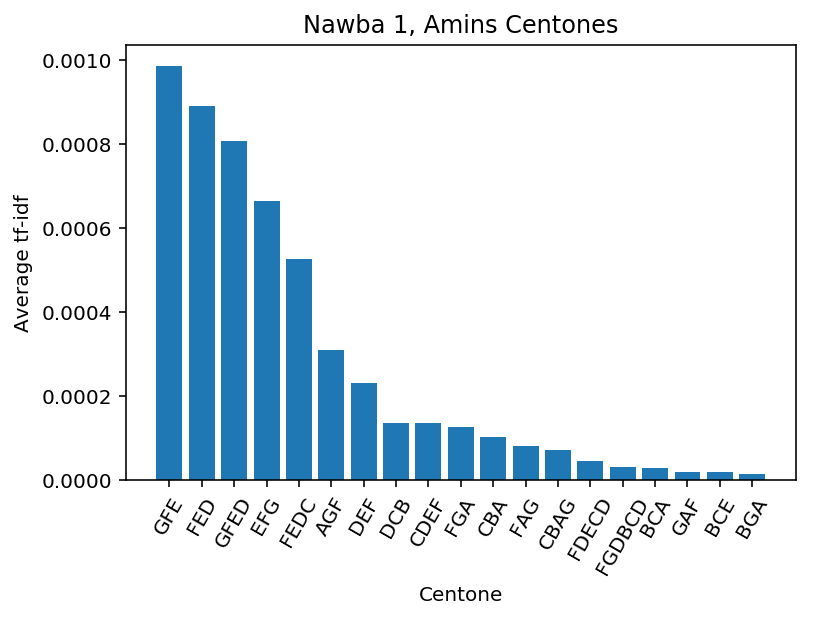

In [142]:
nawba = 'Nawba_{}'.format(i)
reporting.get_amins_plot(frame_grouped, nawba, nawba_centones)
i += 1
if i > len(set(nawba_centones.keys())):
    i = 1

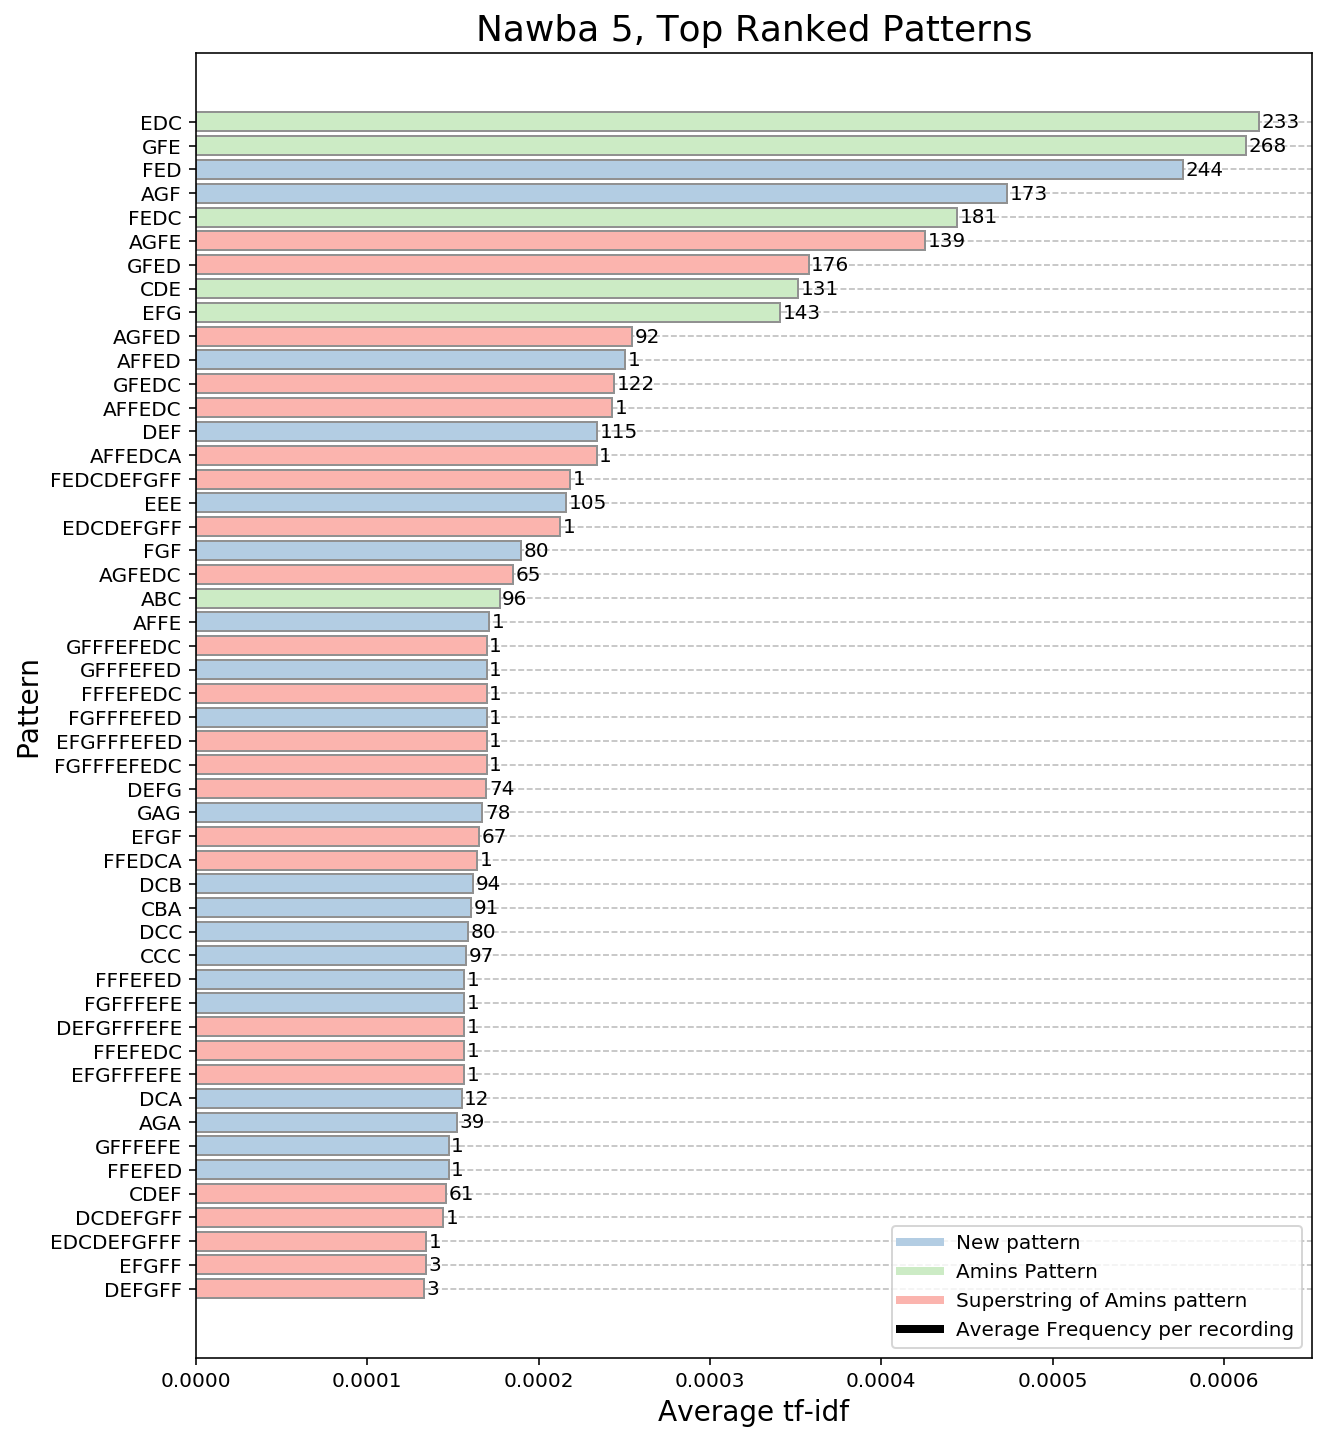

In [317]:
# Bars marked green match amins centones
# Bars marked red are supersets of amins centones
# Bars marked blues are un defined centones
nawba = 'Nawba_{}'.format(i)
reporting.get_top_centones_plot(frame_grouped, nawba, nawba_centones, nawba_scores[nawba], n=50)
i += 1
if i > len(set(nawba_centones.keys())):
    i = 1